In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile
import tensorflow_io as tfio
import soundfile as sf

from sklearn.model_selection import train_test_split

from data import fetch_metadata,path_to_audio, paths_and_labels_to_dataset


%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
yamnet = hub.load('https://tfhub.dev/google/yamnet/1') 

In [3]:
def class_names_from_csv(class_map_csv_text):
    """Returns list of class names corresponding to score vector."""
    class_names = []
    with tf.io.gfile.GFile(class_map_csv_text) as csvfile:
        reader = csv.DictReader(csvfile)
    for row in reader:
        class_names.append(row['display_name'])
    return class_names

class_map_path = yamnet.class_map_path().numpy()
yamnet_class_names = class_names_from_csv(class_map_path)

In [4]:
waveform = tf.io.read_file('/media/wwymak/Storage2/birdsong_dataset/xeno_canto_eu_cleaned/great_tit/519998.wav')
waveform, sample_rate = tf.audio.decode_wav(waveform)
# audio = tf.squeeze(audio, axis=-1)
waveform = tf.cast(waveform, tf.float32)
waveform = tfio.audio.resample(
    waveform, rate_in=tf.cast(sample_rate, tf.int64), rate_out=16_000, name=None
)
scores, embeddings, spectrogram = yamnet(tf.squeeze(waveform, axis=[-1]))

scores_np = scores.numpy()
spectrogram_np = spectrogram.numpy()
infered_class = yamnet_class_names[scores_np.mean(axis=0).argmax()]
print(f'The main sound is: {infered_class}')

The main sound is: Animal


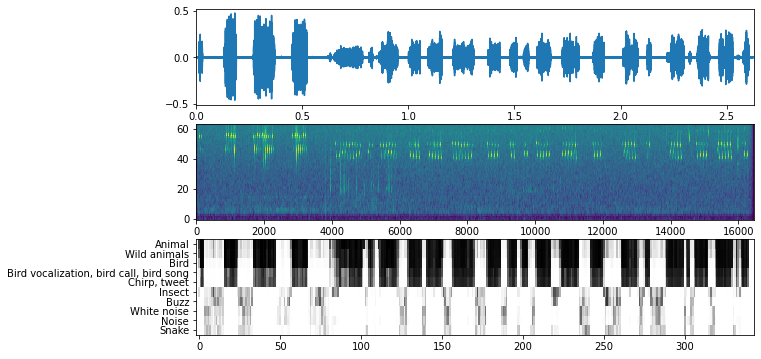

In [5]:
plt.figure(figsize=(10, 6))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])

# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram_np.T, aspect='auto', interpolation='nearest', origin='lower')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_n = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
plt.subplot(3, 1, 3)
plt.imshow(scores_np[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')

# patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
# values from the model documentation
patch_padding = (0.025 / 2) / 0.01
plt.xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
# Label the top_N classes.
yticks = range(0, top_n, 1)
plt.yticks(yticks, [yamnet_class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_n, 0]))

In [6]:
birdsong_metadata = fetch_metadata()
dataset = birdsong_metadata[birdsong_metadata.label_string.isin(['great_tit', 'eurasian_blackcap'])].copy()
dataset["label"] = dataset.label_string.apply(lambda x: 1 if x=='great_tit' else 0)

train_audio_paths, valid_audio_paths, train_labels, valid_labels = train_test_split(
    dataset[["filepath"]], dataset["label"], stratify=dataset["label"], test_size=0.2, random_state=101
)

filepaths = pd.concat([train_audio_paths, valid_audio_paths])
folds = pd.Series([0] * len(train_audio_paths) + [1] * len(valid_audio_paths))
targets = pd.concat([train_labels, valid_labels])

In [7]:
main_ds = tf.data.Dataset.from_tensor_slices((filepaths.values.squeeze(), targets.values.squeeze(), folds.values.squeeze()))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [8]:
@tf.function
def load_wav_16k_mono(filename):
    """ read in a waveform file and convert to 16 kHz mono """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

def load_wav_for_map(filename, label, fold):
    return load_wav_16k_mono(filename), label, fold

def extract_embedding(wav_data, label, fold):
    ''' run YAMNet to extract embedding from the wav data '''
    
    scores, embeddings, spectrogram = yamnet(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

def paths_and_labels_to_dataset(audio_paths, labels):
    """Constructs a dataset of audios and labels."""
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(lambda x: tf.py_function(path_to_audio, [x], [tf.float32]))
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))


def path_to_audio(path, output_sample_rate=16_000, audio_length=30):
    """Reads and decodes an audio file."""
    audio = tf.io.read_file(path)
    audio, sample_rate = tf.audio.decode_wav(audio)
    # audio = tf.squeeze(audio, axis=-1)
    audio = tf.cast(audio, tf.float32)
    audio = tfio.audio.resample(
        audio, rate_in=tf.cast(sample_rate, tf.int64), rate_out=output_sample_rate, name=None
    )
    effective_length = output_sample_rate * audio_length

    if audio.shape[0] < effective_length:
        padding=(effective_length - audio.shape[0])
        padding_start =  padding// 2
        padding_end = padding- padding_start

        paddings = tf.constant([[padding_start, padding_end ], [0,0]])
        # 'constant_values' is 0.
        # rank of 't' is 2.
        audio = tf.pad(audio, paddings, "CONSTANT")
    elif audio.shape[0] > effective_length:
        start = np.random.randint(low=0, high=(audio.shape[0] - effective_length))

        audio = audio[start:start+effective_length, :]
    audio = tf.squeeze(audio, axis=[-1])
    return audio

In [9]:
main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [10]:
# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [11]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold ==0)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold ==1)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [12]:
ym_finetune_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
], name='ym_finetune_model')

ym_finetune_model.summary()

Model: "ym_finetune_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_________________________________________________________________


In [15]:
ym_finetune_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="test_model_2_birds",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    ),
    tf.keras.callbacks.TensorBoard(
        log_dir="./logs",
        update_freq="batch",
    )  # How often to write logs (default: once per epoch)
]
history = ym_finetune_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callbacks)

Epoch 1/20
      1/Unknown - 0s 191us/step - loss: 0.7526 - accuracy: 0.4688WARNING:tensorflow:From /home/wwymak/anaconda3/envs/birdsong_recognition/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


   7144/Unknown - 836s 117ms/step - loss: 0.3396 - accuracy: 0.8534
Epoch 00001: val_loss improved from inf to 0.51183, saving model to test_model_2_birds
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: test_model_2_birds/assets


INFO:tensorflow:Assets written to: test_model_2_birds/assets


7175/7175 [==============================] - 839s 117ms/step - loss: 0.3395 - accuracy: 0.8535 - val_loss: 0.5118 - val_accuracy: 0.7636
Epoch 2/20
7144/7175 [============================>.] - ETA: 0s - loss: 0.3167 - accuracy: 0.8648
Epoch 00002: val_loss did not improve from 0.51183
7175/7175 [==============================] - 7s 923us/step - loss: 0.3166 - accuracy: 0.8648 - val_loss: 0.5274 - val_accuracy: 0.7665
Epoch 3/20
7144/7175 [============================>.] - ETA: 0s - loss: 0.3021 - accuracy: 0.8703
Epoch 00003: val_loss did not improve from 0.51183
7175/7175 [==============================] - 7s 917us/step - loss: 0.3020 - accuracy: 0.8704 - val_loss: 0.5582 - val_accuracy: 0.7623
Epoch 4/20
7166/7175 [============================>.] - ETA: 0s - loss: 0.2904 - accuracy: 0.8766
Epoch 00004: val_loss did not improve from 0.51183
7175/7175 [==============================] - 7s 926us/step - loss: 0.2904 - accuracy: 0.8766 - val_loss: 0.5999 - val_accuracy: 0.7588
Epoch 5/20


In [17]:
scores, embeddings, spectrogram = yamnet(tf.squeeze(waveform, axis=[-1]))
result = ym_finetune_model(embeddings).numpy()

infered_class = ['eurasian_blackcap','great_tit', ][result.mean(axis=0).argmax()]
print(f'The main sound is: {infered_class}')

The main sound is: great_tit
